### Imports:

In [1]:
import numpy as np
import datetime as dt
import time
import matplotlib.pyplot as plt
from pandas import Series, DataFrame, read_json, to_datetime
#from pandas import Timedelta

### Exemplos "originais" (via Telegram):

In [111]:
dados = read_json('https://api.binance.com/api/v3/klines?symbol=BTCUSDT&interval=15m&limit=340')
dados2 = read_json('https://api.binance.com/api/v3/klines?symbol=VETUSDT&interval=15m&startTime=1628125200000&endTime=1628989200000&limit=1000')

### Exemplos interativos:

In [113]:
symbol = 'BTCUSDT'
interval='15m'
limit='340'

dados3 = read_json('https://api.binance.com/api/v3/klines?symbol={}&interval={}&limit={}'.format(
   symbol, interval, limit)
)

dados3.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1634457600000,60329.54,60615.14,60322.85,60588.51,314.46693,1634458499999,1.901490e+07,11691,168.99883,1.021849e+07,0
1,1634458500000,60588.51,60838.08,60588.50,60777.80,292.36952,1634459399999,1.774073e+07,11567,156.60431,9.502824e+06,0
2,1634459400000,60777.79,60912.48,60670.00,60746.62,282.55987,1634460299999,1.716953e+07,11131,138.20306,8.398383e+06,0
3,1634460300000,60746.61,60808.98,60670.00,60670.93,170.12108,1634461199999,1.032838e+07,8751,79.49017,4.826569e+06,0
4,1634461200000,60670.92,60835.00,60619.89,60804.98,263.51974,1634462099999,1.599613e+07,10230,122.97884,7.465726e+06,0


59401.12
66875.83
0.11176997728476788


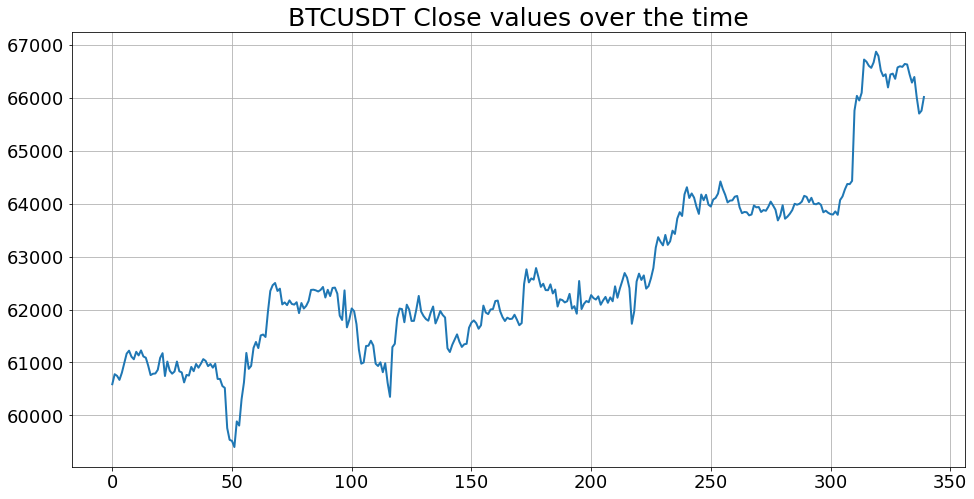

In [114]:
fig = dados3[4].plot(figsize = (16,8), grid=True, fontsize = 18, linewidth=2.0)
plt.title(f'{symbol} Close values over the time', fontdict = {'fontsize' : 25})


print(dados3[4].min())
print(dados3[4].max())

print((dados3[4].max() - dados3[4].min())/(dados3[4].max()))


In [119]:
symbol = 'VETUSDT'
interval='15m'
limit='1000'

data_inicio = '2021-08-04'
horario_inicio = '22:00'

data_fim = '2021-08-14'
horario_fim = '22:00'

startTime = int(dt.datetime.fromisoformat(data_inicio+'T'+horario_inicio).timestamp()) * 1000
endTime = int(dt.datetime.fromisoformat(data_fim+'T'+horario_fim).timestamp()) * 1000

dados4 = read_json('https://api.binance.com/api/v3/klines?symbol={}&interval={}&startTime={}&endTime={}&limit={}'.format(
   symbol, interval, startTime, endTime, limit)
)

dados4.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1628125200000,0.08766,0.08781,0.08715,0.08750,8970288.9,1628126099999,784309.393265,1862,4190426.2,366426.641583,0
1,1628126100000,0.08749,0.08794,0.08715,0.08739,5273980.2,1628126999999,461475.225651,881,2096332.3,183510.766137,0
2,1628127000000,0.08740,0.08789,0.08740,0.08770,2742793.3,1628127899999,240564.612551,652,1184607.7,103880.676020,0
3,1628127900000,0.08769,0.08849,0.08743,0.08841,5081190.2,1628128799999,447512.057374,933,3331613.9,293561.271792,0
4,1628128800000,0.08841,0.08920,0.08828,0.08913,6231756.1,1628129699999,553489.299184,1587,3777593.6,335479.304425,0


### Percorrendo os indices do tipo datetime usando .loc[]:

In [7]:
dados[12] = to_datetime(dados[0].apply(lambda x : dt.datetime.fromtimestamp(x/1000)))
dados.set_index(12, inplace=True)

In [8]:
dados.loc['2021-10-15 01:00:00':'2021-10-16 04:20:37']

,0,1,2,3,4,5,6,7,8,9,10,11
12,,,,,,,,,,,,
2021-10-15 01:00:00,1634270400000,59431.70,59490.00,59142.86,59167.71,983.017478,1634271299999,5.833616e+07,25278,468.516388,2.781086e+07,0
2021-10-15 01:15:00,1634271300000,59167.71,59669.00,59161.79,59528.33,1280.415982,1634272199999,7.611992e+07,39799,749.708917,4.459223e+07,0
2021-10-15 01:30:00,1634272200000,59528.34,59630.10,59366.94,59630.10,776.046220,1634273099999,4.617894e+07,20687,411.820700,2.450644e+07,0
2021-10-15 01:45:00,1634273100000,59630.10,59700.00,59482.80,59597.64,925.947859,1634273999999,5.523269e+07,22984,556.294659,3.319024e+07,0
2021-10-15 02:00:00,1634274000000,59597.64,59823.69,59554.50,59755.03,1148.237920,1634274899999,6.856902e+07,31944,801.191697,4.784284e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-16 03:15:00,1634364900000,62187.48,62319.77,62000.00,62190.55,415.790870,1634365799999,2.582850e+07,15428,225.892260,1.403383e+07,0
2021-10-16 03:30:00,1634365800000,62190.54,62209.79,62035.58,62044.09,227.034210,1634366699999,1.409849e+07,12002,119.791570,7.438431e+06,0
2021-10-16 03:45:00,1634366700000,62044.08,62100.00,61856.00,61856.00,318.632810,1634367599999,1.974443e+07,13903,176.060790,1.091085e+07,0


### Coletando dados de um range largo de datas e exportando resultados:

In [2]:
def gerar_csv_dados_cripto(symbol, interval, limit, data_inicio=None, horario_inicio=None, data_fim=None, horario_fim=None, log=True):
    if(interval == '1m'):
        delta = dt.timedelta(hours=16)
    elif(interval == '3m'):
        delta = dt.timedelta(days=2)
    elif(interval == '5m'):
        delta = dt.timedelta(days=3)
    elif(interval == '15m'):
        delta = dt.timedelta(days=10)
    elif(interval == '30m'):
        delta = dt.timedelta(days=20)
    elif(interval == '1h'):
        delta = dt.timedelta(days=40)
    elif(interval == '2h'):
        delta = dt.timedelta(days=80)
    elif(interval == '4h'):
        delta = dt.timedelta(days=160)
    elif(interval == '6h'):
        delta = dt.timedelta(days=240)
    elif(interval == '8h'):
        delta = dt.timedelta(days=320)
    elif(interval == '12h'):
        delta = dt.timedelta(days=480)
    elif(interval == '1d'):
        delta = dt.timedelta(days=1000)
    elif(interval == '3d'):
        delta = dt.timedelta(days=3000)
    elif(interval == '1w'):
        delta = dt.timedelta(weeks=1000)
    elif(interval == '1M'):
        delta = dt.timedelta(weeks=4000)
    else:
        raise ValueError('intervalError')
        
    if(horario_inicio == None):
        horario_inicio = '00:00:00'
    if(horario_fim == None):
        #horario_fim = dt.datetime.now()
        #horario_fim = str(horario_fim.hour)+':'+str(horario_fim.minute)+':'+str(horario_fim.second)
        horario_fim = '23:59:59'
        
    if(limit > 1000):
        limit = 1000
    if(limit <= 0):
        raise ValueError('limitError')
        
    if(data_inicio == None):
        path_dados = 'https://api.binance.com/api/v3/klines?symbol={}&interval={}&limit={}'.format(
            symbol, interval, limit
        )
        dados_atual = read_json(path_dados).iloc[:, :5]
        dados_atual.insert(loc=0, column='Date-Time', value = dados_atual[0].apply(lambda x : dt.datetime.fromtimestamp(x/1000)))
        
        print('Gerando arquivo .csv...')

        dados_atual.columns = ['Date-Time', 'Timestamp', 'Open', 'Max', 'Min', 'Close']
        dados_atual.set_index('Date-Time', inplace=True)

        dados_atual.to_csv(f'dados_{symbol}_{interval}.csv')

        print('Procedimento realizado com sucesso!')
    
        return
    elif((data_inicio != None) and (data_fim != None)):
        path_dados_base = 'https://api.binance.com/api/v3/klines?symbol={}&interval={}&startTime={}&endTime={}&limit={}'
        limit = 1000
    else:
        data_fim = dt.datetime.now()
        data_fim = str(data_fim.year)+'-'+str(data_fim.month)+'-'+str(data_fim.day)
        
        path_dados_base = 'https://api.binance.com/api/v3/klines?symbol={}&interval={}&startTime={}&endTime={}&limit={}'
        
        limit = 1000

    data_atual = dt.datetime.fromisoformat(data_inicio+'T'+horario_inicio)

    dados_list = [ [], [], [], [], [], [] ]
    
    primeiro_laco = True

    momento_final = dt.datetime.fromisoformat(data_fim+'T'+horario_fim)
    momento_final_timestamp = int(dt.datetime.timestamp(momento_final)) * 1000
    
    it_count = 1
    
    while(data_atual < momento_final):
        if(log):
            print('Iteracao Atual:', it_count)
            print('Data Atual:', data_atual)

        startTime = int(data_atual.timestamp()) * 1000
        aux_endTime = int( (data_atual + delta).timestamp()) * 1000
        if(aux_endTime < momento_final_timestamp):
            endTime = aux_endTime
        else:
            endTime = momento_final_timestamp

        dados_atual = read_json(path_dados_base.format(symbol, interval, startTime, endTime, limit))
        
        if(primeiro_laco):
            dados_list[0].extend([dt.datetime.fromtimestamp(dados_atual[0][0]/1000)])
            dados_list[1].extend([dados_atual[0][0]])
            dados_list[2].extend([dados_atual[1][0]])
            dados_list[3].extend([dados_atual[2][0]])
            dados_list[4].extend([dados_atual[3][0]])
            dados_list[5].extend([dados_atual[4][0]])
            
        dados_list[0].extend((dados_atual[0][1:]/1000).apply(lambda x : dt.datetime.fromtimestamp(x)).tolist())
        #dados_list[0].extend(to_datetime(dados_atual[0][1:], unit='ms', origin='unix') - Timedelta('03:00:00'))
        dados_list[1].extend(dados_atual[0][1:])
        dados_list[2].extend(dados_atual[1][1:])
        dados_list[3].extend(dados_atual[2][1:])
        dados_list[4].extend(dados_atual[3][1:])
        dados_list[5].extend(dados_atual[4][1:])

        data_atual += delta
        it_count += 1
        
        primeiro_laco = False

    print('Gerando arquivo .csv...')        

    dados_completo = DataFrame(dados_list).T
    dados_completo.columns = ['Date-Time', 'Timestamp', 'Open', 'Max', 'Min', 'Close']
    dados_completo.set_index('Date-Time', inplace=True)

    dados_completo.to_csv(f'dados_{symbol}_{interval}.csv')

    print('Procedimento realizado com sucesso!')
    
    return

In [3]:
gerar_csv_dados_cripto(symbol='VETUSDT', interval='30m', limit=1000, data_inicio='2021-09-01')

Iteracao Atual: 1
Data Atual: 2021-09-01 00:00:00
Iteracao Atual: 2
Data Atual: 2021-09-21 00:00:00
Iteracao Atual: 3
Data Atual: 2021-10-11 00:00:00
Gerando arquivo .csv...
Procedimento realizado com sucesso!
